Clasic:

In [1]:
from math import *
import numpy as np
import numpy.fft as  fft
import pandas as pd
import matplotlib.pyplot as plt

import librosa as lr#read and manipulate audio file
import librosa.display

In [2]:
#take file
#amplitudes-signal amplitude
#sfreq-nr timePoints/sec
amplitudes,sfreq =lr.load("ArchiveWAV/sunet.wav",11205)
time=np.arange(0,len(amplitudes))/sfreq #create time array

In [3]:
#play sound
import IPython.display as ipd
ipd.Audio(amplitudes,rate=sfreq)

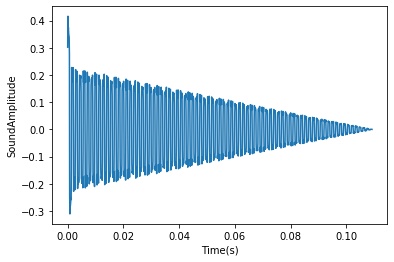

In [4]:
#plot amplitude
fig ,ax=plt.subplots()
ax.plot(time,amplitudes)
ax.set(xlabel='Time(s)',ylabel='SoundAmplitude')
plt.show()

C:\Users\Voicu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  import sys


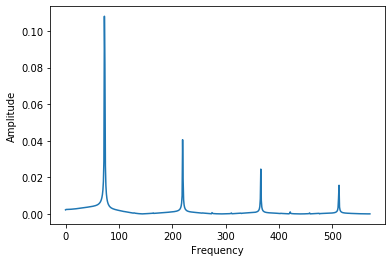

In [5]:
#applied fourier transform and plot 

famplitudes=fft.fft(amplitudes)
n=len(amplitudes)
T=1/sfreq
yf=famplitudes
xf=np.linspace(0,0.1/(2.0*T)+10,n/2)
fig,ax=plt.subplots()
ax.plot(xf,2.0/n*np.abs(yf[:n//2]))
ax.set(xlabel='Frequency',ylabel='Amplitude')
plt.show()

Quantum code

In [6]:
#import Qiskit

from qiskit import BasicAer, Aer ,IBMQ
from qiskit.aqua.components.qfts import Standard as qft

from qiskit import QuantumRegister,ClassicalRegister,QuantumCircuit,execute

from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.tools.visualization import plot_histogram


In [7]:
IBMQ.save_account('ae3eea413b98f53a07979e58a63c61020eec0e5de949c370ac79fa791d98156e501e3aa29ab16b64e4207aade400753052d2180597599117f286a726175bc899')

Credentials already present. Set overwrite=True to overwrite.


In [8]:
#convert to quantum format
def get_StatevectorFromSpec(amplitudes):
    
    n=int(np.log2(len(amplitudes)))# nr of qubits
    n2=pow(2,n);n2=int(n2) #nr of possible states 
    
    minimum = min(amplitudes[0:n2])
    amplitudeq=[amplitudes[i]  for i in range(0,n2)] # only 2^k elemt can be store  => the new sound will be shorter 
    m=len(amplitudeq)
    ssum=0
    for i in range(m):
        ssum+=amplitudeq[i]**2 

    stateVector=[complex(amplitudeq[i]/np.sqrt(ssum)) for i in range(m)] # because is a state vector sum over all items must be 1 
    floatStatevector=[amplitudeq[i]/np.sqrt(ssum) for i in range(m)]
    return stateVector,floatStatevector

def get_pozitivStatevectorFromSpec(amplitudes):
    
    n=int(np.log2(len(amplitudes)))# nr of qubits
    n2=pow(2,n);n2=int(n2) #nr of possible states 
    
    minimum = min(amplitudes[0:n2])
    amplitudeq=[amplitudes[i]+1  for i in range(0,n2)] # move to 0-2  I want positive amplitudes (0.3^2=(-0.3)^2 -wiill be an overlab wen make mesurements) and only 2^k elemt can be store  => the new sound will be shorter 
    m=len(amplitudeq)
    ssum=0
    for i in range(m):
        ssum+=amplitudeq[i]**2 

    stateVector=[complex(amplitudeq[i]/np.sqrt(ssum)) for i in range(m)] # because is a state vector sum over all items must be 1 
    floatStatevector=[amplitudeq[i]/np.sqrt(ssum) for i in range(m)]
    return stateVector,floatStatevector

In [9]:
stateVector,floatStateVector=get_StatevectorFromSpec(amplitudes)
pozitivStateVector,floatpozitivStateVector=get_pozitivStatevectorFromSpec(amplitudes)
n2=len(stateVector)
#lost the last part because 2^k 
Time=[time[i] for i in range(n2)]

Overv all signal:

In [10]:
#lost the last part because 2^k 
Time=[time[i] for i in range(len(stateVector))]

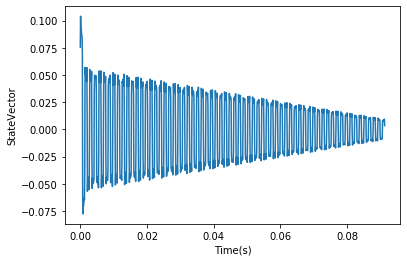

In [11]:
#plot Statevector (t)
fig ,ax=plt.subplots()
ax.plot(Time,floatStateVector)
ax.set(xlabel='Time(s)',ylabel='StateVector')
plt.show()

In [12]:
#play stateVector
ipd.Audio(floatpozitivStateVector*10,rate=sfreq)

In [13]:
# creat register 
n=int(np.log2(len(pozitivStateVector)))
q=QuantumRegister(n,'q')
c=ClassicalRegister(n,'c')
qc=QuantumCircuit(q,c)

qc.initialize(pozitivStateVector,q)

qc.measure(range(n), range(n))
   

In [14]:
#run qc

#provider=IBMQ.load_account()
#backend=provider.get_backend('ibmq_qasm_simulator')
backend = Aer.get_backend('qasm_simulator')

shot=102000 #too big 
counts = execute(qc,backend=backend,shots=shot).result().get_counts(qc)

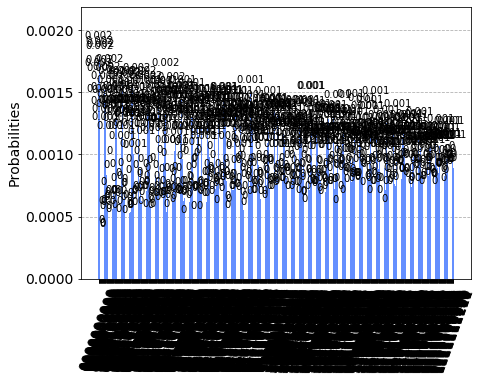

In [15]:
plot_histogram(counts, sort='asc') #It's not the most beautiful reprezentation and take a lot of time 

In [16]:
#extract amplitudes from counts
def extractAmplitudesfromCounts(n2,counts,shots):
    
    amplitudes=np.zeros(n2)
    
    key_max = max(counts.keys(), key=(lambda k: counts[k]))
    max_val = counts[key_max]
    med = shots/n2
    
    for key in counts:
        i=int(key,2)
        val=counts[key] 
        amplitudes[i]=(counts[key] - med)/max_val
        
    return amplitudes

def extractAmplitudesfromCounts2(n2, counts, shots):
    #extract amplitudes from counts
    Amplitudes=[0*i for i in range (n2)]
    for key in counts:
        i=int(key,2)
        val=(counts[key]) 
        Amplitudes[i]=val
    for i in range(n2):
        Amplitudes[i]=(Amplitudes[i]*100/shot) #100 just for amplification
        
    return Amplitudes

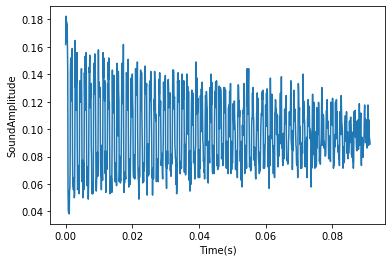

In [17]:
#plot the output of qc 

Amplitudes=extractAmplitudesfromCounts2(n2,counts,shot)

fig ,ax=plt.subplots()
ax.plot(Time,(Amplitudes))
ax.set(xlabel='Time(s)',ylabel='SoundAmplitude')
plt.show()

In [18]:
#play quantum sound
ipd.Audio(Amplitudes,rate=sfreq)

In [19]:
#Now wea apply FT

from qiskit.aqua.components.qfts import Standard as qft

n=int(np.log2(len(stateVector)))
fq=QuantumRegister(n,'q')
fc=ClassicalRegister(n,'c')
fqc=QuantumCircuit(q,c)

fqc.initialize(stateVector,q) 

qft(n).construct_circuit(qubits=fq,circuit=fqc)

fqc.measure(range(n), range(n))

In [20]:
#nr of shots is small if we are interested the in string frequences even lower if we are interested only in the dominant frequency

shot=100
fcounts=execute(fqc,backend=backend,shots=shot).result().get_counts(fqc)

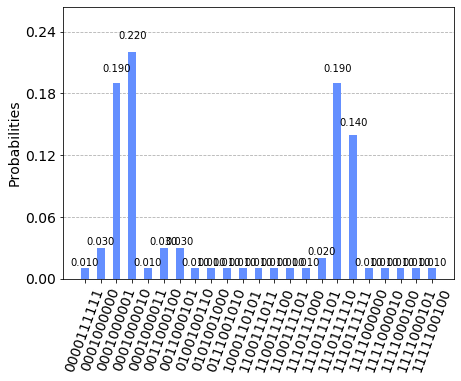

In [21]:
plot_histogram(fcounts, sort='asc')

C:\Users\Voicu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  import sys


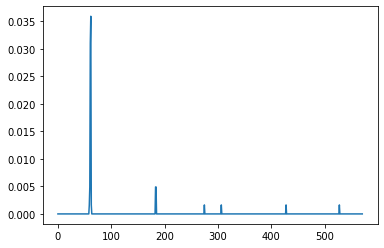

In [22]:
#applied fourier transform and plot 

FAmplitudes=extractAmplitudesfromCounts2(n2,fcounts,shot)
n=len(amplitudes)
T=1/sfreq
yf=FAmplitudes
xf=np.linspace(0,0.1/(2.0*T)+10,n/2)
fig,ax=plt.subplots()
ax.plot(xf,2.0/n*np.abs(yf[:n//2]))
plt.show()

In [23]:
#max frequencies in time 

key_max = max(counts.keys(), key=(lambda k: counts[k]))
max_val = counts[key_max]

fmax=int(key_max ,2)


Now we cut our time in little pieces to find max frequencies at some point in time

In [24]:
#pastime- size of a time piece
#OBS !! now only 5 qbits are e enought
pastime=int(pow(2,5)) 
st=0

In [25]:
def createCirc(stateVector) :
    n=int(np.log2(len(stateVector)))
    fq=QuantumRegister(n,'q')
    fc=ClassicalRegister(n,'c')
    fqc=QuantumCircuit(q,c)

    fqc.initialize(stateVector,q) 

    qft(n).construct_circuit(qubits=fq,circuit=fqc)

    fqc.measure(range(n), range(n))

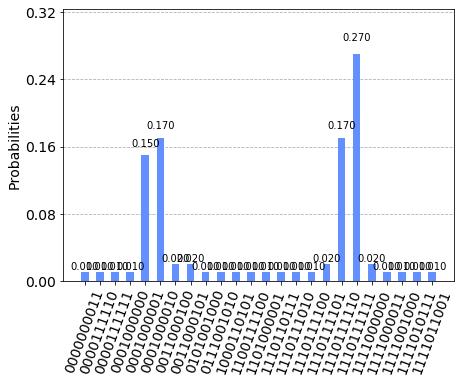

In [26]:
#Exemple for first time step

i=1
a=pastime*i
pasamplitude=[amplitudes[k] for k in range(a,pastime*(i+1))]

passtatevector,floatPstatevector=get_StatevectorFromSpec(amplitudes)

createCirc(passtatevector)
shot=100
fcounts=execute(fqc,backend=backend,shots=shot).result().get_counts(fqc)
    
plot_histogram(fcounts, sort='asc')



C:\Users\Voicu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """


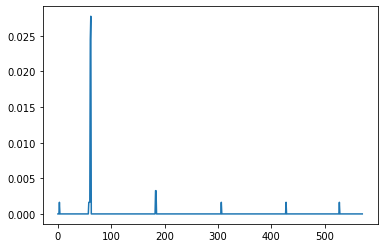

In [27]:
FAmplitudes=extractAmplitudesfromCounts2(n2,fcounts,shot)
n=len(amplitudes)
T=1/sfreq
yf=FAmplitudes
xf=np.linspace(0,0.1/(2.0*T)+10,n/2)
fig,ax=plt.subplots()
ax.plot(xf,2.0/n*np.abs(yf[:n//2]))
plt.show()

In [28]:
np.argmax(FAmplitudes)

959

Disclaimer: The algorithm presented above is a very superficial one and is just for the sake of proving the concept.

In [29]:
#extract  max frequencies at time a-a+pastime
def extractMaxFr3(amplitudes,pastime,i):
    
    a=pastime*i
    pasamplitude=[amplitudes[k] for k in range(a,pastime*(i+1))]

    passtatevector,floatPstatevector=get_StatevectorFromSpec(amplitudes)

    createCirc(passtatevector)
    shot=1000 # work even with 300
    fcounts=execute(fqc,backend=backend,shots=shot).result().get_counts(fqc)

    A=np.zeros(len(amplitudes))
    for key in fcounts:
        o=int(key,2)
        val=fcounts[key] 
        A[o]=fcounts[key] 
    li=[np.abs(A[o]+A[-o])for o in range (int(len(A)/2))]
    
    fmax0=np.argmax(li)
   
   
    return fmax0,li

In [30]:
compres=int(len(time)/pastime)
compresTime=[i for i in range(compres)]
FMAX0=np.zeros(compres) 
fTlist=[[0][0]for i in range(compres)]
 
for i in range (compres):
    FMAX0[i],fTlist[i]=extractMaxFr3(amplitudes,pastime,i)

In [31]:
FMAX0[0]

267.0

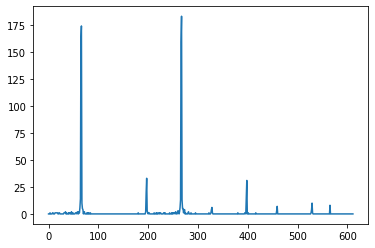

In [32]:
plt.plot(fTlist[0])
plt.show()

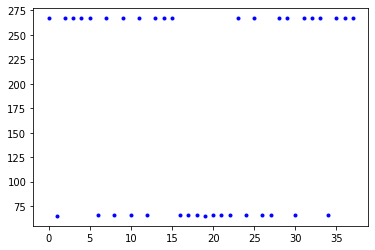

In [33]:
#max frequency
plt.plot(compresTime, FMAX0, 'b.')
plt.show()

Future plan:
I intend to implement a proper program for max frequency identification and then,try to create a complete quantum program for songs or diverse sound recognition inspired from Shazam algorithm.